In [77]:
import pandas as pd
import numpy as np
from copy import deepcopy
from datetime import datetime
import pickle
import time
import gzip
import datetime
import dateutil
import os
import re
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline 
#%config InlineBackend.figure_format = 'svg'
plt.style.use("ggplot") 

In [78]:
log=pd.read_csv('StatisticsData2016NoiseFree.csv', delimiter= ',')
float_cols = log.select_dtypes(include=['float'])
for col in float_cols.columns:
    log[col] = pd.to_numeric(log[col], downcast ='float')
    
int_cols = log.select_dtypes(include=['int64'])
for col in int_cols.columns:
    log[col] = pd.to_numeric(log[col], downcast ='integer')

In [79]:
#TABLE OF PERSONS:
#Replacing "nan" values with "-", to unable concatenation of columns:
log['Creator']=log['Creator'].fillna('-')
log['CreatorDept']=log['CreatorDept'].fillna('-')
log['AssignedTo']=log['AssignedTo'].fillna('-')
log['ActivityTranslation']=log['ActivityTranslation'].fillna('-')
log['AssigneeDept']=log['AssigneeDept'].fillna('-')

#PERSONS WHO HAVE BEEN ASSIGNING TASKS TO OTHERS:
log['tmp2']=log['Creator']+ ', '+ log['CreatorDept']    
assigners_list=list(set(list(log['tmp2']))) 
assigners_names=[]
assigner_dept=[]
for el in assigners_list:
    if type(el)==str: #'nan' value has type 'float' - must be left out
        content=el.split(', ')
        assigners_names.append(content[0])
        assigner_dept.append(content[1])
assigners=pd.DataFrame()
assigners['name']=assigners_names
assigners['dept']=assigner_dept
    
#PERSONS TO WHOME TASKS HAVE BEEN ASSIGNED:
log['tmp']=log['AssignedTo']+ ', '+ log['ActivityTranslation'] + ', '+ log['AssigneeDept']    
persons_list=list(set(list(log['tmp']))) 
names=[]
country=[]
position=[]
dept=[]
for el in persons_list:
    if type(el)==str: #'nan' value has type 'float' - must be left out
        content=el.split(', ')
        names.append(content[0])
        c=content[1].split(' ')[0]
        country.append(c)
        position.append(re.sub(c+' ', '', content[1]))
        dept.append(content[2])
persons=pd.DataFrame()
persons['name']=names
persons['country']=country
persons['dept']=dept
persons['position']=position
persons['assignee']=True

is_assigner=[]
for i, name in enumerate(names):
    if name in assigners_names:
        is_assigner.append(True)
    else:
        is_assigner.append(False)
persons['assigner']=is_assigner

#Assigners who are not assignees:
a=set(assigners_names)
b=set(names)
c=a-b
for name in c:
    idx=assigners_names.index(name)
    row=[assigners_names[idx], '-', assigner_dept[idx], '-', False, True]
    #print(row)
    tmp=pd.DataFrame([row], columns=persons.columns.values)
    persons=persons.append(tmp, ignore_index=True)


In [80]:
#The best way of filling up the values is to first update the persons table, so that each person appears there 
#only once, with his/her department, country and position, if these exist in any of the rows (or "-" if not). 
    
#Updating persons table:
names=list(persons["name"])
countries=list(persons["country"])
depts=list(persons["dept"])
positions=list(persons["position"])
assignees=list(persons["assignee"])
assigners=list(persons["assigner"])

#Empty dictionary:
persons2=list(set(persons["name"].unique())) #132
dict={}
for person in persons2:
    d={"country": "-", "dept": "-", "position": "-", "assignee": True, "assigner": True}
    dict[person]=d

#For unique data for persons, let's gather it to dictionary:
for i, name in enumerate(names):
    if countries[i]!="-":
        dict[name]["country"]=countries[i]
    if depts[i]!="-":
        dict[name]["dept"]=depts[i]    
    if positions[i]!="-":
        dict[name]["position"]=positions[i]
    dict[name]["assignee"]=assignees[i]
    dict[name]["assigner"]=assigners[i]

persons= pd.DataFrame.from_dict(dict).T

In [81]:
#Now, we will analyse the few still missing values separately:

#Michaela seems to be a special case, because she is the only one with "HUB" as both country and position value.
#To distinguish her from others, let's also fill her dept value as "HUB":
persons["dept"]["Michaela"]="HUB"

#The person "Customer" is such a special case that it would seem useful to also fill it's country and position
#values with something different than the rest of the "other" values. Let's fill those values also with the value 
#"Customer":
persons["country"]["Customer"]="Customer"
persons["position"]["Customer"]="Customer"

#All the rest of the missing values cannot be guessed, and should be filled up with "other":
persons=persons.replace(to_replace='-', value='other')


In [82]:
#Now let's fill up the missing department, country and position values also in the large dataframe. In order to do 
#use dataFrame.replace() function for that, we need to make dictionaries for the replacement values to be used for 
#the respective columns. In order to apply replacing based on a dictionary (where keys are persons' names and values 
#are dept, position or country), we also need to replace the repsective column in the large dataframe with persons 
#names first, because the replace() function doesn't allow making replacements based on values in another column.

#Dictionaries of replacement values:
countries=persons["country"].to_dict()
depts=persons["dept"].to_dict()
positions=persons["position"].to_dict()

#Replacing values in the main dataframe:
#tmp=log[:500]
a=log["AssignedTo"]
a=a.replace(to_replace=depts)
log=log.drop(columns=["AssigneeDept"])
log["AssigneeDept"]=a

a=log["Creator"]
a=a.replace(to_replace=depts)
log=log.drop(columns=["CreatorDept"])
log["CreatorDept"]=a

a=log["AssignedTo"]
a=a.replace(to_replace=positions)
log=log.drop(columns=["ActivityTranslation"])
log["AssigneePosition"]=a

#Adding the country column:
a=log["AssignedTo"]
a=a.replace(to_replace=countries)
log["AssigneeCountry"]=a

#Dropping temporary columns:
log=log.drop(columns=["tmp2"])
log=log.drop(columns=["tmp"])


In [83]:
#ANALYSING EFFICIENCY (AVERAGE WORKED MINUTES) AND THE NON-RECORDING OF WORKING TIME:
#It would seem interesting to see if there are any specific departments, positions or countries that systematically
#do not record their working time.

worked=log.groupby(["AssignedTo"])["WorkedMinutes"].sum().to_dict()
#Add persons who are only assigners, with zero TotalWorked value:
for assigner in c:
    worked[assigner]=0

#persons["totalWorked"]=persons.index
a=pd.Series(list(persons.index))
a=a.replace(to_replace=worked)
persons["totalWorked"]=list(a)

#From this table, we can see that there is no particular country where employees don't record their working times. 
#An exception is the country code "HUB" (only used for a single person, Michaela), who does not record her working time.
#The reason for not recording her worked time might be that she is engaded in some central administrative tasks. 

In [84]:
# EMPLOYEES BY COUNTRY AND DEPARTMENT:

def company_structure(persons, z, title, col, y_title): #col- 'dept' or 'position'
#    z=z.drop(columns=["assigner", "assignee", "position"])
    cols=persons[col].unique() #col="dept"
    #persons["country"].unique() #'other', 'UK', 'FR', 'ITA', 'Customer', 'HUB'
    dict={}
    for c in cols:
        d={"FR": 0, "UK": 0, "ITA": 0, "other": 0, "Customer": 0, "HUB": 0}
        dict[c]=d
    
    countries=list(z["country"])
    cols=list(z[col])
    worked=list(z["totalWorked"])    
#    assignees=list(persons["assignee"])
    
    #Number of employees per country and department:
    for i, c in enumerate(cols):
        country=countries[i]
#        dict[dept][countries[i]]=assignees[i]
        dict[c][countries[i]]=worked[i]
    
    countries_df= pd.DataFrame.from_dict(dict).T
    countries_df=countries_df.drop(columns=["Customer"]) #"HUB" each includes only one person, with no country and department
    countries_df=countries_df.drop(index=["Customer"]) 
    countries_df["total"]=countries_df["UK"]+ countries_df["FR"]+ countries_df["ITA"]+ countries_df["other"]+countries_df["HUB"]
    countries_df.sort_values(by=["total"], ascending=False, inplace=True)
    countries_df=countries_df.drop(columns=["total"])
    
    #Plotting number of employees by country and department:
    plt.figure();
    if "Average" in title:
        countries_df.plot(kind='bar', figsize=[7,5]);
    else:
        countries_df.plot(kind='bar', figsize=[7,4], stacked=True);
    plt.ylabel(y_title)
    if col=="dept":
        plt.xlabel('Departments')
    else:
        plt.xlabel('Positions')   
    plt.title(title)

In [85]:
# We are going to leave out all the tasks that have not been completed yet and that reported 0 minutes
log['SignOff'] = log.SignOff.replace(' ', np.nan)
log['TotalMinutes'] = log.TotalMinutes.replace(0, np.nan)
log.dropna(inplace= True, subset=['TotalMinutes', 'SignOff'])
len(log)

210847

In [86]:
# parsing the datestamps
log['ActionTimeStamp'] = log['ActionTimeStamp'].apply(dateutil.parser.parse, dayfirst=True)
log['CreateTime'] = log['CreateTime'].apply(dateutil.parser.parse, dayfirst=True)
log['SignOff'] = log['SignOff'].apply(dateutil.parser.parse, dayfirst=True)

In [87]:
# Number of actions per task 
data_groupedPerson= log.groupby('ID')['AssignedTo'].count()
data_groupedPerson
actions =[]
for value in data_groupedPerson:
    actions.append(value)
data_groupedPerson = pd.DataFrame(data_groupedPerson)
data_groupedPerson['ID'] = data_groupedPerson.index
data_groupedPerson.rename(columns={'AssignedTo': 'Actions'})
data = pd.merge(log, data_groupedPerson, on="ID")
log = data.rename(columns={'AssignedTo_x': 'AssignedTo', 'AssignedTo_y': 'Actions' })

/home/jcool12/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3265: FutureWarning: 'ID' is both an index level and a column label.
Defaulting to column, but this will raise an ambiguity error in a future version
  exec(code_obj, self.user_global_ns, self.user_ns)


In [88]:
# Adding the year column
years = []
for i in log.ActionTimeStamp:
    years.append(i.year)
log['year'] = years

In [89]:
# Adding the month column
months = []
for i in log.ActionTimeStamp:
    months.append(i.month)
log['months'] = months

Text(0.5, 0, 'Months/Year')

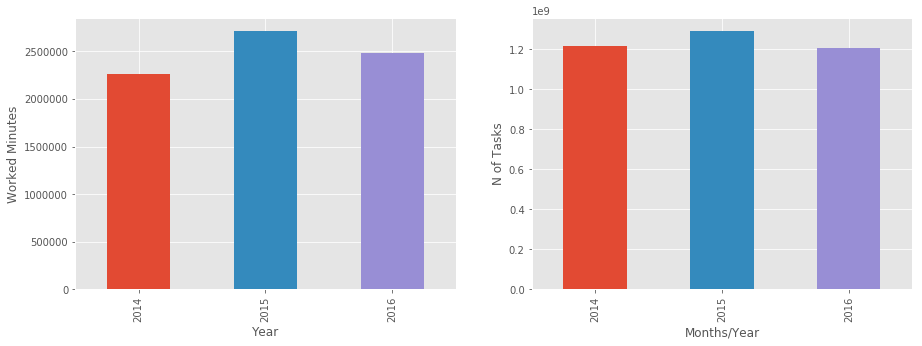

In [90]:
#Evaluate the workload per year

back = log.copy()
back.sort_values(by = 'TotalMinutes', ascending=False)
back.drop_duplicates(subset='ID', inplace=True)

f = plt.figure(figsize=(15,5))
ax = f.add_subplot(121)
log.groupby(['year'])['WorkedMinutes'].sum().plot(kind = 'bar')
plt.ylabel('Worked Minutes')
plt.xlabel('Year')

ax2 = f.add_subplot(122)
back.groupby(['year'])['ID'].sum().plot(kind = 'bar')
plt.ylabel('N of Tasks')
plt.xlabel('Months/Year')

2015 is the year where a higher amount of tasks and worked minutes is registred. We can notice that to a higher amount of tasks is corresponded, in general, a higher amount of worked minutes over the years

Text(0.5, 0, 'Months')

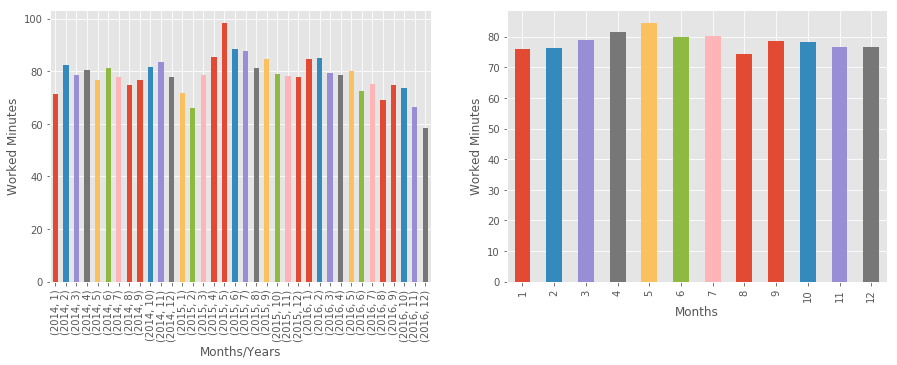

In [91]:
#Evaluate the workload per month
f = plt.figure(figsize=(15,5))
ax = f.add_subplot(121)
work_over_years = log.groupby(['year','months'])['WorkedMinutes'].mean()
work_over_years.plot(x = 'months', y= 'WorkedMinutes', kind = 'bar')
plt.ylabel('Worked Minutes')
plt.xlabel('Months/Years')

ax2 = f.add_subplot(122)
log.groupby(['months'])['WorkedMinutes'].mean().plot(kind='bar')
plt.ylabel('Worked Minutes')
plt.xlabel('Months')

If we look at the months, we cannot find a clear schema of the minutes worked for every task by employees. Just in general, we can say that April and May seem to be the months where there is more productivity, while the worked minutes tend to drop in August (probably because of the employees' annual leaves).

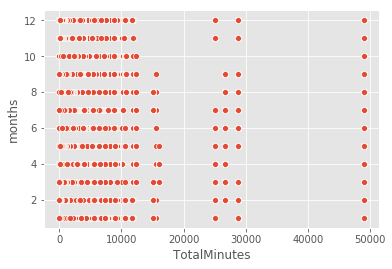

In [92]:
# Evaluate the Total Minutes over the months
ax = sns.scatterplot(x="TotalMinutes", y="months", data=log)

As we can see from the scatterplot, there are certain tasks that lasted a significant amount of time dragging themselves in some cases over 1 year (in one occasion even 3 years) before signing off. Let's look which are these tasks and to which type they belong to

,ID,ActionID,Type,CreateTime,SignOff,Source,Creator,ActionTimeStamp,AssignedTo,TotalMinutes,...,EstimateInMinutes,Category,SubCategory,AssigneeDept,CreatorDept,AssigneePosition,AssigneeCountry,Actions,year,months
22052,114958,2342202,Enhancement,2014-04-14 20:11:00,2016-02-26 18:20:00,Internal,Alvaro,2014-04-14 20:11:00,Alvaro,48949.0,...,-1.0,7,15,Development,Development,Senior Coder,FR,155,2014,4
89849,126820,2808886,Enhancement,2015-02-26 12:20:00,2016-09-09 12:42:00,Internal,Landyn,2015-02-26 12:20:00,Landyn,28820.0,...,-1.0,7,96,Development,Development,Advanced Tech Support,FR,117,2015,2
87557,126436,2795242,Enhancement,2015-02-17 16:57:00,2015-10-08 12:36:00,Internal,Alvaro,2015-02-17 16:57:00,Alvaro,26605.0,...,-1.0,7,28,Development,Development,Senior Coder,FR,91,2015,2
67294,122836,2677402,Delivery,2014-11-19 14:24:00,2016-11-23 11:48:00,Internal,Eliana,2014-11-19 14:24:00,Eliana,24987.0,...,10200.0,7,103,Development,Development,Senior Coder,FR,127,2014,11
90549,126937,2812860,Enhancement,2015-03-02 14:38:00,2015-12-04 15:20:00,Internal,Michelle,2015-03-02 14:38:00,Lailah,15979.0,...,2400.0,7,2,Development,Development,Senior Coder,FR,42,2015,3
5662,112182,2266154,Enhancement,2014-01-30 20:11:00,2015-03-03 15:41:00,Internal,Rosie,2014-01-30 20:11:00,Rosie,15604.0,...,15000.0,11,103,Development,Development,Senior Coder,FR,41,2014,1
80841,125135,2744036,Problem,2015-01-22 16:14:00,2015-12-03 10:55:00,Internal,Angeline,2015-01-22 16:14:00,Michaela,15169.0,...,1200.0,5,90,HUB,Support2,HUB,HUB,51,2015,1
95900,127863,2848727,Enhancement,2015-03-25 12:06:00,2016-09-08 16:39:00,Internal,Brantley,2015-03-25 12:06:00,Brantley,12415.0,...,600.0,11,103,Testing,Testing,Test,FR,90,2015,3
74934,124160,2714333,Internal,2014-12-21 17:24:00,2016-01-04 11:49:00,Internal,Anabella,2014-12-21 17:24:00,Anabella,11844.0,...,12000.0,3,103,Support2,Support2,Tech Support,ITA,137,2014,12
145275,136607,3170452,Enhancement,2015-12-01 18:05:00,2016-02-18 17:09:00,Internal,Eliana,2015-12-01 18:05:00,Alvaro,11636.0,...,-1.0,2,103,Development,Development,Senior Coder,FR,33,2015,12


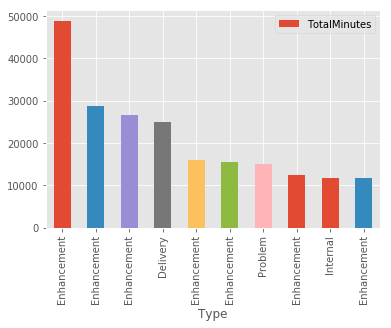

In [93]:
b = back.sort_values(by = 'TotalMinutes', ascending=False).head(10)
b.plot(y = 'TotalMinutes', x = 'Type', kind = 'bar')
b

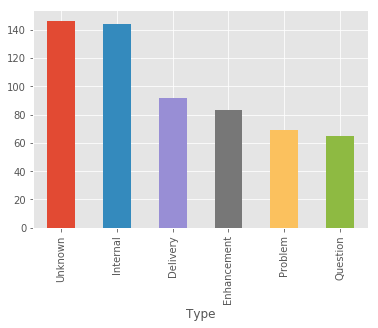

In [94]:
# find the categories were on average most worked minutes are spent
log.groupby(['Type'])['WorkedMinutes'].mean().sort_values(ascending = False).plot(kind = 'bar')

The tasks that exceed 20.000 minutes are 4 and they belong mostly to the type 'Enhancement' plus one task in Delivery. Overall, these are not the type categories where the highest values of worked minutes are spent. Let's look at the actions of these 4 tasks to look if we can find some mutual characteristics

In [95]:
loc = log.loc[log['ID'].isin([114958, 126820, 126436, 122836]) ]
with pd.option_context("display.max_rows", 1000):
    display(loc)

,ID,ActionID,Type,CreateTime,SignOff,Source,Creator,ActionTimeStamp,AssignedTo,TotalMinutes,...,EstimateInMinutes,Category,SubCategory,AssigneeDept,CreatorDept,AssigneePosition,AssigneeCountry,Actions,year,months
22052,114958,2342202,Enhancement,2014-04-14 20:11:00,2016-02-26 18:20:00,Internal,Alvaro,2014-04-14 20:11:00,Alvaro,48949.0,...,-1.0,7,15,Development,Development,Senior Coder,FR,155,2014,4
22053,114958,2342423,Enhancement,2014-04-14 20:11:00,2016-02-26 18:20:00,Internal,Alvaro,2014-04-14 22:10:00,Alvaro,48949.0,...,-1.0,7,15,Development,Development,Senior Coder,FR,155,2014,4
22054,114958,2343234,Enhancement,2014-04-14 20:11:00,2016-02-26 18:20:00,Internal,Alvaro,2014-04-15 17:57:00,Alvaro,48949.0,...,-1.0,7,15,Development,Development,Senior Coder,FR,155,2014,4
22055,114958,2344902,Enhancement,2014-04-14 20:11:00,2016-02-26 18:20:00,Internal,Alvaro,2014-04-16 21:25:00,Alvaro,48949.0,...,-1.0,7,15,Development,Development,Senior Coder,FR,155,2014,4
22056,114958,2349143,Enhancement,2014-04-14 20:11:00,2016-02-26 18:20:00,Internal,Alvaro,2014-04-21 19:03:00,Alvaro,48949.0,...,-1.0,7,15,Development,Development,Senior Coder,FR,155,2014,4
22057,114958,2350371,Enhancement,2014-04-14 20:11:00,2016-02-26 18:20:00,Internal,Alvaro,2014-04-22 17:36:00,Alvaro,48949.0,...,-1.0,7,15,Development,Development,Senior Coder,FR,155,2014,4
22058,114958,2351803,Enhancement,2014-04-14 20:11:00,2016-02-26 18:20:00,Internal,Alvaro,2014-04-23 18:11:00,Alvaro,48949.0,...,-1.0,7,15,Development,Development,Senior Coder,FR,155,2014,4
22059,114958,2354830,Enhancement,2014-04-14 20:11:00,2016-02-26 18:20:00,Internal,Alvaro,2014-04-25 21:29:00,Alvaro,48949.0,...,-1.0,7,15,Development,Development,Senior Coder,FR,155,2014,4
22060,114958,2356578,Enhancement,2014-04-14 20:11:00,2016-02-26 18:20:00,Internal,Alvaro,2014-04-28 20:18:00,Alvaro,48949.0,...,-1.0,7,15,Development,Development,Senior Coder,FR,155,2014,4
22061,114958,2357654,Enhancement,2014-04-14 20:11:00,2016-02-26 18:20:00,Internal,Alvaro,2014-04-29 17:42:00,Alvaro,48949.0,...,-1.0,7,15,Development,Development,Senior Coder,FR,155,2014,4


By looking more deeply into these long-lasting tasks, we can notice that all of them have been taken care by one person only for each task and that the employee performed a high number of actions on them (> 90). Furthermore, all these employees belong to the same Department (Development), same category (n. 7) and they work in the same country as well, France. Importantly to notice is that these tasks were Internal and not provided by Customer. We can probably think of these tasks as some important optimizations of the company system that require a significative amount of time to be implemented and assigned to the some of the most expert developers in the company (Alvaro who has of these enhancements is a senior coder, as well as Eliana, while Landyn is an Advanced Tech Support)

In [96]:
# For the purpose of our model, we would like to predict standard tasks that require a total duration before 
# completing the task which is less than 1 year and for this reason we are going to leave out these outstanding cases
log = log.sort_values(by = 'TotalMinutes', ascending= False)
log = log.iloc[490:].sort_values(by = 'TotalMinutes', ascending= False)

In [97]:
# how many different employees reported the WorkedMinutes per every year
backup = log.copy()
df = pd.DataFrame(backup.groupby(['AssignedTo', 'year'], as_index= False)['WorkedMinutes'].agg(lambda x: x.mean() ))
df = df.dropna().sort_values(by = 'WorkedMinutes', ascending = False)
df = df.sort_values(by = ['year', 'WorkedMinutes'], ascending = False)
print(len(df.loc[df.year == 2016]))
print(len(df.loc[df.year == 2015]))
print(len(df.loc[df.year == 2014]))

60
45
49


We can see that out of the 122 employees present in the data, only a maximum of 60 influenced the WorkedMinutes in a single year

Text(0.5, 0, '2014')

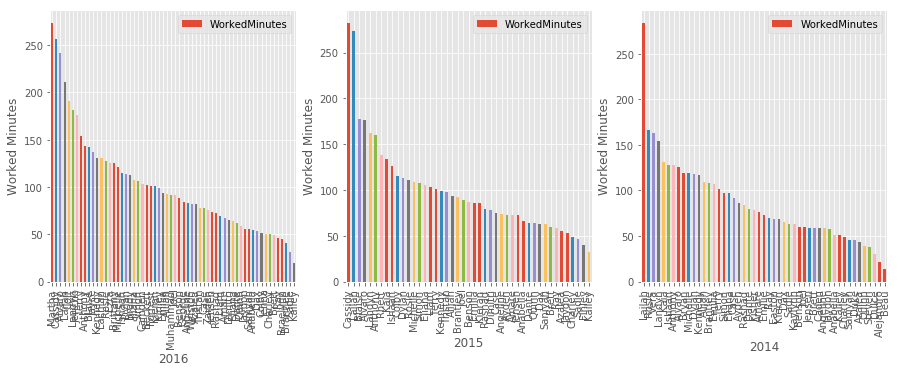

In [98]:
# Distribution of the average worked minutes of employees per year
f = plt.figure(figsize=(15,5))
ax = f.add_subplot(131)
df.loc[df.year == 2016].plot(kind = 'bar', x = 'AssignedTo', y = 'WorkedMinutes', ax = ax)
plt.ylabel('Worked Minutes')
plt.xlabel('2016')

ax2 = f.add_subplot(132)
df.loc[df.year == 2015].plot(kind = 'bar', x = 'AssignedTo', y = 'WorkedMinutes', ax = ax2)
plt.ylabel('Worked Minutes')
plt.xlabel('2015')

ax3 = f.add_subplot(133)
df.loc[df.year == 2014].plot(kind = 'bar', x = 'AssignedTo', y = 'WorkedMinutes', ax = ax3)
plt.ylabel('Worked Minutes')
plt.xlabel('2014')

The power-low distribution is similar over the years for employees worked minutes

In [99]:
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.metrics import mean_squared_error
from math import sqrt

In [100]:
log.corr()

,ID,ActionID,TotalMinutes,WorkedMinutes,EstimateInMinutes,Category,SubCategory,Actions,year,months
ID,1.000000,0.976606,-0.037409,-0.022932,-0.020531,0.067970,0.157279,-0.079248,0.908364,0.247592
ActionID,0.976606,1.000000,0.023128,-0.013194,0.001769,0.081869,0.174311,0.008705,0.935590,0.241361
TotalMinutes,-0.037409,0.023128,1.000000,0.391908,0.284981,0.051756,0.080436,0.665086,0.028037,-0.010564
WorkedMinutes,-0.022932,-0.013194,0.391908,1.000000,0.054893,0.037030,0.042627,0.102536,-0.011358,-0.005227
EstimateInMinutes,-0.020531,0.001769,0.284981,0.054893,1.000000,-0.002321,0.070615,0.259778,0.003312,-0.007354
Category,0.067970,0.081869,0.051756,0.037030,-0.002321,1.000000,0.139303,0.044039,0.058366,0.072671
SubCategory,0.157279,0.174311,0.080436,0.042627,0.070615,0.139303,1.000000,0.078726,0.141547,0.107298
Actions,-0.079248,0.008705,0.665086,0.102536,0.259778,0.044039,0.078726,1.000000,0.013942,-0.010363
year,0.908364,0.935590,0.028037,-0.011358,0.003312,0.058366,0.141547,0.013942,1.000000,-0.112962
months,0.247592,0.241361,-0.010564,-0.005227,-0.007354,0.072671,0.107298,-0.010363,-0.112962,1.000000


In [101]:
# The only remarkable value that seems to correlate with TotalMinutes is Actions. However, when a task is first 
# assigned to somebody, we don't know how many actions will be performed on it. We could think then that we could 
# predict the actions making a regression model for them and use these predictions to predict afterwards the 
# TotalMinutes. However, to see if this is worthy to do, let's verify first if actions would be a good predictor 
#for TotalMinutes by using them in a regression model to retrieve TotalMinutes

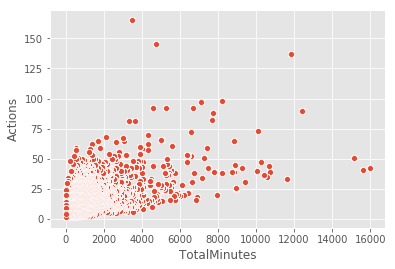

In [102]:
ax = sns.scatterplot(x="TotalMinutes", y="Actions", data=log)

We can notice in general that a task lasts longer according to the number of actions that are performed in it

MSE:  790987.8133145141
RMSE:  889.3749565366197


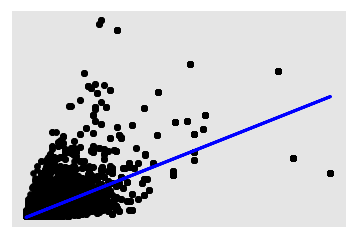

In [103]:
import math
# Regression with X = Actions, y = TotalMinutes
try_model = log.copy()
X = log.Actions.values
y = try_model.TotalMinutes.values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
clf = linear_model.LinearRegression()
X_train= X_train.reshape(-1, 1)
y_train= y_train.reshape(-1, 1)
X_test = X_test.reshape(-1, 1)
reg = clf.fit(X_train, y_train)
y_pred = reg.predict(X_test)
print('MSE: ',mean_squared_error(y_test, y_pred))
print('RMSE: ',math.sqrt(mean_squared_error(y_test, y_pred)))
plt.scatter(X_test, y_test,  color='black')
plt.plot(X_test, y_pred, color='blue', linewidth=3)

plt.xticks(())
plt.yticks(())

plt.show()

In [104]:
# As we can see from the chart, most of the points are grouped in the bottom corner, leaving the regression model
# with a poor score (RMSE: 888). For this reason, Actions would not probably be a good predictor for our output

In [105]:
try_model = log.copy()
# Convert categories into integers
try_model.Source.replace('Customer', 0, inplace= True)
try_model.Source.replace('Internal', 1, inplace= True)
try_model.WorkedMinutes.replace(np.nan, 0, inplace= True)
# Drop no-relevant columns for the model
try_model.drop(['CreateTime'], axis = 1, inplace= True)
try_model.drop(['ActionID'], axis = 1, inplace= True)
try_model.drop(['ActionTimeStamp'], axis = 1, inplace= True)
try_model.drop(['SubCategory'], axis = 1, inplace= True)
try_model.drop(['Actions'], axis = 1, inplace= True)
try_model.drop(['SignOff'], axis = 1, inplace= True)
try_model.drop(['Creator'], axis = 1, inplace= True)
try_model.drop(['year'], axis = 1, inplace= True)
try_model.head()

,ID,Type,Source,AssignedTo,TotalMinutes,WorkedMinutes,EstimateInMinutes,Category,AssigneeDept,CreatorDept,AssigneePosition,AssigneeCountry,months
90575,126937,Enhancement,1,Lailah,15979.0,419.0,2400.0,7,Development,Development,Senior Coder,FR,4
90561,126937,Enhancement,1,Lailah,15979.0,422.0,2400.0,7,Development,Development,Senior Coder,FR,3
90550,126937,Enhancement,1,Lailah,15979.0,207.0,2400.0,7,Development,Development,Senior Coder,FR,3
90549,126937,Enhancement,1,Lailah,15979.0,0.0,2400.0,7,Development,Development,Senior Coder,FR,3
90554,126937,Enhancement,1,Lailah,15979.0,78.0,2400.0,7,Development,Development,Senior Coder,FR,3


In [106]:
# a function that given an input will return the average value of it grouped by WorkedMinutes
def add_columnWM (try_model, variable):
    AvgTime = try_model.groupby(variable)['WorkedMinutes'].mean()
    df = pd.DataFrame(AvgTime)
    try_model = pd.merge(try_model, df, on=variable)
    try_model = try_model.rename(columns={'WorkedMinutes_x': 'WorkedMinutes', 'WorkedMinutes_y': 'AvgTime'+variable+'WM'})
    return try_model

In [107]:
# a function that given an input will return the average value of it grouped by TotalMinutes
def add_columnTM (try_model, variable):
    AvgTime = try_model.groupby(variable)['TotalMinutes'].mean()
    df = pd.DataFrame(AvgTime)
    try_model = pd.merge(try_model, df, on=variable)
    try_model = try_model.rename(columns={'TotalMinutes_x': 'TotalMinutes', 'TotalMinutes_y': 'AvgTime'+variable+'TM'})
    return try_model

In [108]:
# Since the attributes of the df are mostly categorical and our prediction is numeric, we try to retrieve some 
# numeric values from the interaction between our output and inputs in order to facilitate a regression model
try_model = add_columnWM(try_model, 'Source')
try_model = add_columnWM(try_model, 'Category')
try_model = add_columnWM(try_model, 'AssigneeCountry')
try_model = add_columnWM(try_model, 'months')
try_model = add_columnWM(try_model, 'AssigneePosition')
try_model = add_columnWM(try_model, 'Type')
try_model = add_columnWM(try_model, 'AssignedTo')

In [109]:
try_model = add_columnTM(try_model, 'AssigneePosition')
try_model = add_columnTM(try_model, 'Source')
try_model = add_columnTM(try_model, 'Category')
try_model = add_columnTM(try_model, 'months')
try_model = add_columnTM(try_model, 'AssignedTo')
try_model = add_columnTM(try_model, 'Type')
try_model = add_columnTM(try_model, 'AssigneeCountry')
try_model.head()

,ID,Type,Source,AssignedTo,TotalMinutes,WorkedMinutes,EstimateInMinutes,Category,AssigneeDept,CreatorDept,...,AvgTimeAssigneePositionWM,AvgTimeTypeWM,AvgTimeAssignedToWM,AvgTimeAssigneePositionTM,AvgTimeSourceTM,AvgTimeCategoryTM,AvgTimemonthsTM,AvgTimeAssignedToTM,AvgTimeTypeTM,AvgTimeAssigneeCountryTM
0,126937,Enhancement,1,Lailah,15979.0,419.0,2400.0,7,Development,Development,...,57.70528,39.55101,171.586899,729.311031,723.225741,979.653976,621.838662,2056.039751,648.258682,614.600381
1,126937,Enhancement,1,Lailah,15979.0,150.0,2400.0,7,Development,Development,...,57.70528,39.55101,171.586899,729.311031,723.225741,979.653976,621.838662,2056.039751,648.258682,614.600381
2,126937,Enhancement,1,Lailah,15979.0,537.0,2400.0,7,Development,Development,...,57.70528,39.55101,171.586899,729.311031,723.225741,979.653976,621.838662,2056.039751,648.258682,614.600381
3,126937,Enhancement,1,Lailah,15979.0,488.0,2400.0,7,Development,Development,...,57.70528,39.55101,171.586899,729.311031,723.225741,979.653976,621.838662,2056.039751,648.258682,614.600381
4,126937,Enhancement,1,Lailah,15979.0,535.0,2400.0,7,Development,Development,...,57.70528,39.55101,171.586899,729.311031,723.225741,979.653976,621.838662,2056.039751,648.258682,614.600381


In [110]:
# We groupby all the tasks by the characterics on the first action, because when a task is given we don't know
# if there will be future actions
try_model = try_model.groupby(['ID']).first()

In [111]:
print(log.info(memory_usage='deep'))

<class 'pandas.core.frame.DataFrame'>
Int64Index: 210357 entries, 90575 to 20835
Data columns (total 21 columns):
ID                   210357 non-null int32
ActionID             210357 non-null int32
Type                 210357 non-null object
CreateTime           210357 non-null datetime64[ns]
SignOff              210357 non-null datetime64[ns]
Source               210357 non-null object
Creator              210357 non-null object
ActionTimeStamp      210357 non-null datetime64[ns]
AssignedTo           210357 non-null object
TotalMinutes         210357 non-null float64
WorkedMinutes        94440 non-null float32
EstimateInMinutes    109927 non-null float32
Category             210357 non-null int8
SubCategory          210357 non-null int8
AssigneeDept         210357 non-null object
CreatorDept          210357 non-null object
AssigneePosition     210357 non-null object
AssigneeCountry      210357 non-null object
Actions              210357 non-null int64
year                 210357 non

In [112]:
# We are giong to make the dataset lighter downgrading int and float 64
try_model.Source.replace('Customer', 0, inplace= True)
try_model.Source.replace('Customer', 1, inplace= True)

int_cols = try_model.select_dtypes(include=['int64'])

for col in int_cols.columns:
    print(col, 'min:',try_model[col].min(),'; max:',try_model[col].max())
    try_model[col] = pd.to_numeric(try_model[col], downcast ='integer')

float_cols = try_model.select_dtypes(include=['float'])
for col in float_cols.columns:
    try_model[col] = pd.to_numeric(try_model[col], downcast ='float')

print(try_model.info(memory_usage='deep'))

Source min: 0 ; max: 1
months min: 1 ; max: 12
<class 'pandas.core.frame.DataFrame'>
Int64Index: 28528 entries, 111070 to 158649
Data columns (total 26 columns):
Type                         28528 non-null object
Source                       28528 non-null int8
AssignedTo                   28528 non-null object
TotalMinutes                 28528 non-null float32
WorkedMinutes                28528 non-null float32
EstimateInMinutes            10127 non-null float32
Category                     28528 non-null int8
AssigneeDept                 28528 non-null object
CreatorDept                  28528 non-null object
AssigneePosition             28528 non-null object
AssigneeCountry              28528 non-null object
months                       28528 non-null int8
AvgTimeSourceWM              28528 non-null float32
AvgTimeCategoryWM            28528 non-null float32
AvgTimeAssigneeCountryWM     28528 non-null float32
AvgTimemonthsWM              28528 non-null float32
AvgTimeAssigneePositi

In [113]:
# find the values that correlate the most with TotalMinutes
corr = try_model.corr().sort_values(by = 'TotalMinutes', ascending = False)
corr.drop('WorkedMinutes', axis = 0, inplace= True)
corr.drop('EstimateInMinutes', axis = 0, inplace= True)
corr[1 :10]

,Source,TotalMinutes,WorkedMinutes,EstimateInMinutes,Category,months,AvgTimeSourceWM,AvgTimeCategoryWM,AvgTimeAssigneeCountryWM,AvgTimemonthsWM,AvgTimeAssigneePositionWM,AvgTimeTypeWM,AvgTimeAssignedToWM,AvgTimeAssigneePositionTM,AvgTimeSourceTM,AvgTimeCategoryTM,AvgTimemonthsTM,AvgTimeAssignedToTM,AvgTimeTypeTM,AvgTimeAssigneeCountryTM
AvgTimeAssignedToWM,0.229211,0.180989,0.214532,0.074233,0.118012,-0.009669,0.229211,0.293987,0.252490,0.014668,0.524042,0.083107,1.000000,0.459367,0.229211,0.243064,0.008104,0.889018,0.077597,0.211382
AvgTimeAssignedToTM,0.198980,0.179153,0.196739,0.082085,0.103746,-0.009249,0.198980,0.308092,0.136489,0.006444,0.304011,0.066192,0.889018,0.391590,0.198980,0.277669,0.003855,1.000000,0.062785,0.162429
AvgTimeTypeWM,0.342488,0.146872,0.123011,0.127517,0.055818,0.024646,0.342488,0.149030,0.018383,0.013730,0.006805,1.000000,0.083107,-0.000480,0.342488,0.131418,0.001345,0.066192,0.935159,-0.016193
AvgTimeTypeTM,0.267290,0.141765,0.120957,0.145061,0.050069,0.027322,0.267290,0.138102,0.008378,0.009499,0.002865,0.935159,0.077597,-0.004739,0.267290,0.125235,0.001610,0.062785,1.000000,-0.021016
AvgTimeCategoryTM,0.238364,0.130200,0.116025,0.072747,0.311493,0.137877,0.238364,0.899490,0.062046,0.010619,0.117367,0.131418,0.243064,0.160669,0.238364,1.000000,0.009491,0.277669,0.125235,0.035285
AvgTimeCategoryWM,0.294348,0.127992,0.134533,0.072470,0.229617,0.062002,0.294348,1.000000,0.078198,0.005012,0.118764,0.149030,0.293987,0.124929,0.294348,0.899490,0.005452,0.308092,0.138102,0.043257
AvgTimeAssigneePositionTM,0.156136,0.093691,0.086952,0.038101,0.071716,0.005046,0.156136,0.124929,0.207014,0.019960,0.832698,-0.000480,0.459367,1.000000,0.156136,0.160669,0.010722,0.391590,-0.004739,0.209996
AvgTimeAssigneePositionWM,0.152750,0.088579,0.093484,0.013233,0.100462,0.009634,0.152750,0.118764,0.436065,0.022996,1.000000,0.006805,0.524042,0.832698,0.152750,0.117367,0.006024,0.304011,0.002865,0.336236
AvgTimeSourceTM,1.000000,0.081616,0.093626,0.111035,0.086465,0.028606,1.000000,0.294348,0.177066,0.018599,0.152750,0.342488,0.229211,0.156136,1.000000,0.238364,0.019407,0.198980,0.267290,0.081718


In [114]:
# It emerges that, in order, the Assignee, the Type, the Category (department) and the Position are the categories
# that better correlate with TotalMinutes. However, the values are really low foretelling that probably the regression
# model will not be very performant due to too little correlating variables

In [115]:
# We do a first try of the regression model selecting only these most correlated categories
subset = try_model.reindex(columns=['AvgTimeAssignedToTM','AvgTimeAssignedToWM','AvgTimeCategoryTM', 'AvgTimeCategoryWM', 'AvgTimeTypeWM', 'AvgTimeTypeTM', 'EstimateInMinutes', 'TotalMinutes'])

In [116]:
# Since we decided to evaluate the model comparing our predictions to the Estimations for the task present in the
# dataset, we use as test set the tasks for which these values are integrated
print(len(subset))
print(len(subset[subset['EstimateInMinutes'] > 0]))
test_set = subset[subset['EstimateInMinutes'] > 0]
subset.loc[:, "hash"] = subset.apply(lambda x: hash(tuple(x)), axis = 1)
test_set.loc[:, "hash"] = test_set.apply(lambda x: hash(tuple(x)), axis = 1)
train_set = subset.loc[~subset["hash"].isin(test_set["hash"]), :]
print(len(train_set))
# shuffle the sets
test_set = test_set.sample(frac=1)
train_set = train_set.sample(frac=1)

28528
10036
18492


/home/jcool12/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/home/jcool12/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [117]:
train_set.drop('EstimateInMinutes', axis = 1, inplace=True)
y_train = train_set.TotalMinutes
train_set.drop('TotalMinutes', axis = 1, inplace=True)
train_set.drop('hash', axis = 1, inplace= True)
X_train = train_set
test_set.drop('EstimateInMinutes', axis = 1, inplace=True)
y_test = test_set.TotalMinutes
test_set.drop('TotalMinutes', axis = 1, inplace=True)
test_set.drop('hash', axis = 1, inplace= True)
X_test = test_set

In [118]:
clf = linear_model.LinearRegression()
reg = clf.fit(X_train, y_train)
y_pred = reg.predict(X_test)
print('MSE: ',mean_squared_error(y_test, y_pred))
print('RMSE: ',math.sqrt(mean_squared_error(y_test, y_pred)))

MSE:  853237.56
RMSE:  923.7085917647405


In [119]:
clf = linear_model.Ridge (alpha = .5)
clf.fit(X_train, y_train) 
y_pred = clf.predict(X_test)
mean_squared_error(y_test, y_pred)
print('MSE: ',mean_squared_error(y_test, y_pred))
print('RMSE: ',math.sqrt(mean_squared_error(y_test, y_pred)))

MSE:  853237.5355208754
RMSE:  923.7085771610413


In [120]:
# The result of this try has been quite unsuccesful, the RMSE is really high (923)

In [121]:
# For this model, we will use a larger portion of the categories and we we drop the numeric ones created previously
try_model = log.copy()
# Convert categories into integers
try_model.Source.replace('Customer', 0, inplace= True)
try_model.Source.replace('Internal', 1, inplace= True)
try_model.WorkedMinutes.replace(np.nan, 0, inplace= True)
# Drop no-relevant columns for the model
try_model.drop(['CreateTime'], axis = 1, inplace= True)
try_model.drop(['ActionID'], axis = 1, inplace= True)
try_model.drop(['ActionTimeStamp'], axis = 1, inplace= True)
try_model.drop(['SubCategory'], axis = 1, inplace= True)
try_model.drop(['Actions'], axis = 1, inplace= True)
try_model.drop(['SignOff'], axis = 1, inplace= True)
try_model.drop(['Creator'], axis = 1, inplace= True)
try_model.drop(['year'], axis = 1, inplace= True)
# groupyby first task
try_model = try_model.groupby(['ID']).first()
#transform categorical categories into categorical
try_model['Category'] = try_model.Category.astype('category')
try_model['months'] = try_model.months.astype('category')
try_model.drop(['WorkedMinutes'], axis = 1, inplace= True)
try_model.head()

,Type,Source,AssignedTo,TotalMinutes,EstimateInMinutes,Category,AssigneeDept,CreatorDept,AssigneePosition,AssigneeCountry,months
ID,,,,,,,,,,,
111070,Problem,0,Caden,47.0,NaN,1,Support2,Customer,Advanced Tech Support,FR,1
111073,Problem,0,Anabella,20.0,150.0,1,Support2,Customer,Tech Support,ITA,1
111074,Problem,1,Vera,30.0,NaN,1,Development,Development,Senior Coder,FR,1
111076,Problem,0,Charley,163.0,NaN,1,Development,Customer,Team Leader,FR,1
111077,Enhancement,1,Emilia,207.0,240.0,3,Development,Development,Team Leader,FR,10


In [122]:
# encoding all the categorical classes
c =try_model.select_dtypes(include=[object, 'category'])
col = [col for col in c.columns]
try_model = pd.get_dummies(try_model, columns=col)

In [123]:
# split into Train and Test (Test is about 35% of the data)
subset = try_model.copy()
print(len(subset))
print(len(subset[subset['EstimateInMinutes'] > 0]))
test_set = subset[subset['EstimateInMinutes'] > 0]
subset.loc[:, "hash"] = subset.apply(lambda x: hash(tuple(x)), axis = 1)
test_set.loc[:, "hash"] = test_set.apply(lambda x: hash(tuple(x)), axis = 1)
train_set = subset.loc[~subset["hash"].isin(test_set["hash"]), :]
print(len(train_set))
# shuffle the sets
test_set = test_set.sample(frac=1)
train_set = train_set.sample(frac=1)

28528
10036
18492


/home/jcool12/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/home/jcool12/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [124]:
y_train = train_set.TotalMinutes
train_set.drop('TotalMinutes', axis = 1, inplace=True)
train_set.drop('EstimateInMinutes', axis = 1, inplace=True)
train_set.drop('hash', axis = 1, inplace= True)
X_train = train_set
estimations = test_set.EstimateInMinutes
test_set.drop('EstimateInMinutes', axis = 1, inplace=True)
y_test = test_set.TotalMinutes
test_set.drop('TotalMinutes', axis = 1, inplace=True)
test_set.drop('hash', axis = 1, inplace= True)
X_test = test_set

In [125]:
clf = linear_model.LinearRegression()
reg = clf.fit(X_train, y_train)
y_pred = reg.predict(X_test)
print(mean_squared_error(y_test, y_pred))
print(math.sqrt(mean_squared_error(y_test, y_pred)))

5.038538611095093e+25
7098266415889.934


In [126]:
clf = linear_model.Ridge (alpha = .5)
clf.fit(X_train, y_train) 
y_predR = clf.predict(X_test)

print('MSE: ',mean_squared_error(y_test, y_predR))
print('RMSE: ',math.sqrt(mean_squared_error(y_test, y_predR)))

MSE:  843211.3492173644
RMSE:  918.2654023850428


In [127]:
# With a Ridge model the RMSE is better, but the model is still very far from being accurate. In general it 
# performed 5 points less of RMSE as the previous one

In [128]:
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.model_selection import cross_validate
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error

In [129]:
# a function to find the best parameters for the model
def get_best_alpha(model,X,y,alphas):
    kf = KFold(n_splits=3, random_state = 0, shuffle=False)
    results = []
    for alpha in alphas:
        model.set_params(alpha=alpha)
        for train_indexes, test_indexes in kf.split(X):
            X_test, X_val = X.values[train_indexes], X.values[test_indexes]
            y_test, y_val = y.values[train_indexes], y.values[test_indexes]

            model.fit(X_test, y_test)
            mse = mean_squared_error(y_val,model.predict(X_val))
            results.append((alpha, mse))
   

    best_alpha, mse = sorted(results, key=lambda x: x[1])[0]
    return best_alpha, mse

In [130]:
ridge_alphas = np.linspace(0.1, 100, 100)
lasso_alphas = np.linspace(0.001, 5, 100)

print("Ridge best alpha %.4f - Avg MSE %.4f " % get_best_alpha(Ridge(), X_train, y_train, ridge_alphas))
print("Lasso best alpha %.4f - Avg MSE %.4f " % get_best_alpha(Lasso(), X_train, y_train, lasso_alphas))

Ridge best alpha 60.6455 - Avg MSE 35676.5323 


/home/jcool12/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/jcool12/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/home/jcool12/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


Lasso best alpha 0.1020 - Avg MSE 35853.7846 


In [131]:
clf = Ridge(alpha= 20.2818)
clf.fit(X_train, y_train) 
y_pred = clf.predict(X_test)
print('MSE: ',mean_squared_error(y_test, y_pred))
print('RMSE: ',math.sqrt(mean_squared_error(y_test, y_pred)))

lasso = linear_model.Lasso(alpha = 0.1525)
lasso.fit(X_train, y_train) 
y_pred = lasso.predict(X_test)
print('MSE: ',mean_squared_error(y_test, y_pred))
print('RMSE: ',math.sqrt(mean_squared_error(y_test, y_pred)))

MSE:  844732.6787140282
RMSE:  919.093400430026
MSE:  847586.556210115
RMSE:  920.6446416561142


In [132]:
# Now, let's compare the RMSE of the predictions we retrieved  with the estimations provided in the original dataset

print('RMSE of the estimations found in the dataset: ',sqrt(mean_squared_error(y_test, estimations)))
print('RMSE of our predictions: ',sqrt(mean_squared_error(y_test, y_predR)))

RMSE of the estimations found in the dataset:  2269.327212437731
RMSE of our predictions:  918.2654023850428


In [133]:
# It seems that our model, although it's still very distant from predicting the actual values, it's scoring better 
# than the predictions found in the dataset

In [134]:
compare = pd.DataFrame(y_test)
compare['Estimations'] = estimations
compare['Predictions'] = y_predR
compare.head()

,TotalMinutes,Estimations,Predictions
ID,,,
119097,242.0,180.0,58.640373
123527,190.0,120.0,77.351751
120303,852.0,59940.0,114.957843
132689,330.0,300.0,102.608642
120748,9.0,120.0,84.110888


In [135]:
compare2 = compare.copy()

In [136]:
compare.drop('Estimations', axis=1, inplace=True)

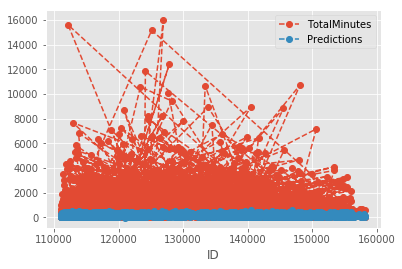

In [137]:
compare.plot( marker='o', linestyle='dashed' )

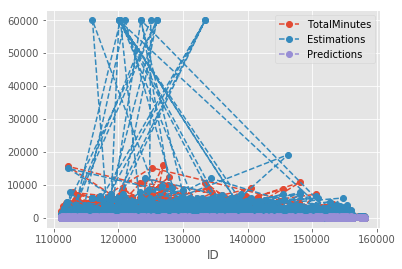

In [138]:
compare2.plot( marker='o', linestyle='dashed')

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fb33820ec18>,
      dtype=object)

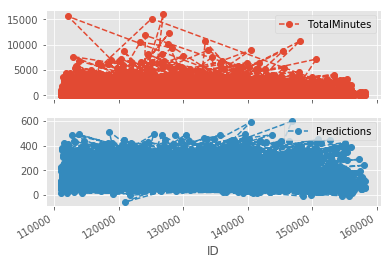

In [139]:
compare.plot( marker='o', linestyle='dashed', subplots=True)

In [140]:
# From the plots, however, we can determine that our model performs better than the estimations only because these
# last ones go very off for few tasks, excluding those maximal items, the estimations seem actually to be quite 
# accurate while there is a clear problem within our model, namely that it didn't predict any task during longer 
# than 600 minutes. Why is that?

In [141]:
# A big drawback for the model is that train and test are split according to the data that has been registred
# for Estimated minutes. If we look more closely, we can notice that there are quite a lot of differences
# between the values that we feed for learning and the ones that we use for evaluating. 
# We can definetely notice this in the mean and std differences, being quite low in the train set in comparison to
# the test set. This big difference between train and test leads to a bad performance of the model. For this reason
# the model really struggles to predict tasks larger than 500 minutes
print(y_train.describe())
y_test.describe()

count    18492.000000
mean       113.053969
std        277.451837
min          1.000000
25%         30.000000
50%         65.000000
75%        135.000000
max      11636.000000
Name: TotalMinutes, dtype: float64


count    10036.000000
mean       522.077023
std        843.454535
min          1.000000
25%        119.000000
50%        281.000000
75%        582.250000
max      15979.000000
Name: TotalMinutes, dtype: float64

In [142]:
# If we would follow a random split of the dataset, the RMSE would improve, but then we will not be able to
# compare the predicted values with the Estimations of the dataset, being the latter missing there
try_model = log.copy()
# Convert categories into integers
try_model.Source.replace('Customer', 0, inplace= True)
try_model.Source.replace('Internal', 1, inplace= True)
try_model.WorkedMinutes.replace(np.nan, 0, inplace= True)
# Drop no-relevant columns for the model
try_model.drop(['CreateTime'], axis = 1, inplace= True)
try_model.drop(['ActionID'], axis = 1, inplace= True)
try_model.drop(['ActionTimeStamp'], axis = 1, inplace= True)
try_model.drop(['SubCategory'], axis = 1, inplace= True)
try_model.drop(['Actions'], axis = 1, inplace= True)
try_model.drop(['SignOff'], axis = 1, inplace= True)
try_model.drop(['Creator'], axis = 1, inplace= True)
try_model.drop(['year'], axis = 1, inplace= True)
# groupyby first task
try_model = try_model.groupby(['ID']).first()
#transform categorical categories into categorical
try_model['Category'] = try_model.Category.astype('category')
try_model['months'] = try_model.months.astype('category')
try_model.drop(['WorkedMinutes'], axis = 1, inplace= True)
try_model.drop('EstimateInMinutes', axis = 1, inplace=True)
# encoding all the categorical classes
c =try_model.select_dtypes(include=[object, 'category'])
col = [col for col in c.columns]
try_model = pd.get_dummies(try_model, columns=col)
# X and y
y = try_model.TotalMinutes
try_model.drop('TotalMinutes', axis = 1, inplace=True)
X = try_model
# randomly splitting train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [143]:
clf = linear_model.LinearRegression()
reg = clf.fit(X_train, y_train)
y_pred = reg.predict(X_test)
print(mean_squared_error(y_test, y_pred))
print(math.sqrt(mean_squared_error(y_test, y_pred)))

1.3315538865596565e+26
11539297580700.727


In [144]:
clf = linear_model.Ridge (alpha = .5)
clf.fit(X_train, y_train) 
y_pred = clf.predict(X_test)
mean_squared_error(y_test, y_pred)
print('MSE: ',mean_squared_error(y_test, y_pred))
print('RMSE: ',math.sqrt(mean_squared_error(y_test, y_pred)))

MSE:  277526.85522655316
RMSE:  526.8081768789785


In [145]:
# RMSE of 526 is the lowest value retrieved

In [146]:
# We can notice that when mean and standard deviation are similar between the train and the test set, the model
# benefits and become more reliable
print(y_train.describe())
y_test.describe()

count    19113.000000
mean       261.346309
std        596.685548
min          1.000000
25%         40.000000
50%        104.000000
75%        247.000000
max      15979.000000
Name: TotalMinutes, dtype: float64


count     9415.000000
mean       248.013489
std        549.754917
min          1.000000
25%         40.000000
50%        101.000000
75%        243.000000
max      15604.000000
Name: TotalMinutes, dtype: float64

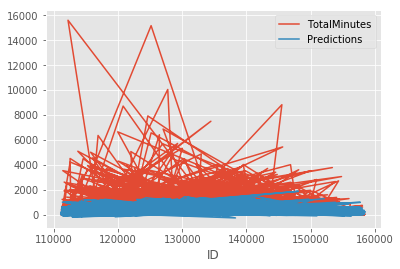

In [147]:
compare = pd.DataFrame(y_test)
compare['Predictions'] = y_pred
compare.plot()

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fb33d1e4860>,
      dtype=object)

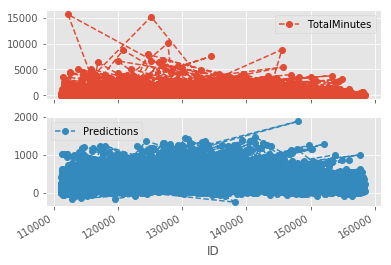

In [148]:
compare.plot( marker='o', linestyle='dashed', subplots=True)

In [149]:
# However, even if the values for predictions increase a little, reaching the 2000 minutes instead of the 600 
# first evaluated, the results are still no satisfying. To improve our model, we can look for another variable. 
# We can assume, that at the beginning of a task, although we won't know how many actions will be performed, we 
# will know how many people will be involved.This is bcs for example a developer will know if the task will be 
# handled by a colleague as well in the same department or if it will have to go to test department later 

In [185]:
ppl_involved = pd.DataFrame(ppl_involved)
ppl_involved['AssignedTo'] = ppl_involved['AssignedTo'].apply(np.ravel)
ppl = []
for line in ppl_involved.AssignedTo.values:
    ppl.append(len(line))
ppl_involved['Ppl_involved'] = ppl
ppl_involved.drop('AssignedTo', axis = 1, inplace = True)
data = pd.merge(log, ppl_involved, on="ID")

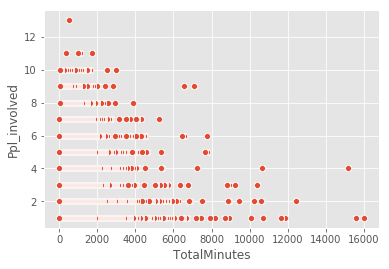

In [205]:
ax = sns.scatterplot(x="TotalMinutes", y="Ppl_involved", data=data)

In [207]:
try_model = data.copy()
try_model = try_model.sample(frac = 1)
# Convert categories into integers
try_model.Source.replace('Customer', 0, inplace= True)
try_model.Source.replace('Internal', 1, inplace= True)
try_model.WorkedMinutes.replace(np.nan, 0, inplace= True)
# Drop no-relevant columns for the model
try_model.drop(['CreateTime'], axis = 1, inplace= True)
try_model.drop(['ActionID'], axis = 1, inplace= True)
try_model.drop(['ActionTimeStamp'], axis = 1, inplace= True)
try_model.drop(['SubCategory'], axis = 1, inplace= True)
try_model.drop(['Actions'], axis = 1, inplace= True)
try_model.drop(['SignOff'], axis = 1, inplace= True)
try_model.drop(['Creator'], axis = 1, inplace= True)
try_model.drop(['year'], axis = 1, inplace= True)
# groupyby first task
try_model = try_model.groupby(['ID']).first()
#transform categorical categories into categorical
try_model['Category'] = try_model.Category.astype('category')
try_model['months'] = try_model.months.astype('category')
try_model.drop(['WorkedMinutes'], axis = 1, inplace= True)
try_model.drop('EstimateInMinutes', axis = 1, inplace=True)
# encoding all the categorical classes
c =try_model.select_dtypes(include=[object, 'category'])
col = [col for col in c.columns]
try_model = pd.get_dummies(try_model, columns=col)
# X and y
y = try_model.TotalMinutes
try_model.drop('TotalMinutes', axis = 1, inplace=True)
X = try_model
# randomly splitting train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [212]:
clf = linear_model.Ridge ()
clf.fit(X_train, y_train) 
y_pred = clf.predict(X_test)
mean_squared_error(y_test, y_pred)
print('MSE: ',mean_squared_error(y_test, y_pred))
print('RMSE: ',math.sqrt(mean_squared_error(y_test, y_pred)))

MSE:  270570.27329267265
RMSE:  520.1636985533233


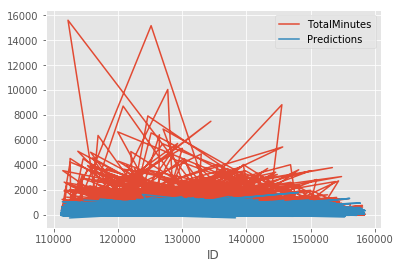

In [213]:
compare = pd.DataFrame(y_test)
compare['Predictions'] = y_pred
compare.plot()

In [219]:
# the model performed slightly better, but still is far from predicting the real values and is horizontally flat
# The result has to be attribued to the fact that there are no variables that strongly correlate with the element
# that we would like to predict. In this case, even if overall we achieved our goal to increase by 15% the values
# of estimations, it seems that relying on the experience of the employees in order to estimate the total amount
# of work per task it seems to be a better option..